# U-Net Segmentation

## Imports

In [1]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [2]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

## Dostęp do Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Kopiowanie datasetu do Google Drive

In [4]:
# !cp -r /content/images /content/drive/MyDrive/Machine_Learning/segmentation_dataset/

In [5]:
# !cp -r /content/annotations /content/drive/MyDrive/Machine_Learning/segmentation_dataset/

Wczytanie datasetu

In [6]:
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Machine_Learning/segmentation_dataset'

Mounted at /content/drive


## Set the necessary paths

In [7]:
input_dir = os.path.join(dataset_path, 'images')
target_dir = os.path.join(dataset_path, 'annotations/trimaps/')
img_size = (160, 160)
num_classes = 3
batch_size = 32
input_img_paths = sorted(os.path.join(input_dir, name) for name in os.listdir(input_dir) if name.endswith('.jpg'))
target_img_paths = sorted(os.path.join(target_dir, name) for name in os.listdir(target_dir) if name.endswith('.png') and not name.startswith("."))

## Images

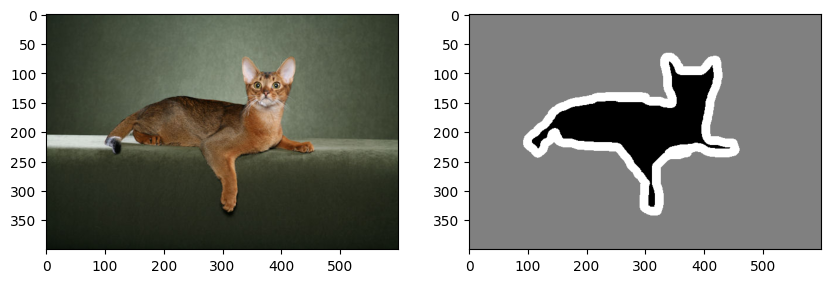

In [8]:
from tensorflow.keras.preprocessing.image import load_img

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(plt.imread(input_img_paths[0]))
axs[1].imshow(plt.imread(target_img_paths[0]), cmap='gray')

plt.show()

## Generator function

In [9]:
from tensorflow import keras

class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y

## Architecture

### Convolution

In [10]:
from tensorflow.keras import layers
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer = "he_normal")(x)
    return x

### Downsapmling

In [11]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.5)(p)
    return f, p

### Upsampling

In [12]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.5)(x)
    x = double_conv_block(x, n_filters)
    return x

### Model

In [13]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

keras.backend.clear_session()
model = get_model(img_size, num_classes)

In [14]:
model = get_model(img_size, num_classes)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 160, 160, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 160, 160, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 80, 80, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 80, 80, 64)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 80, 80, 128)    │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 80, 80, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 40, 40, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 40, 40, 128)    │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 40, 40, 256)    │        295,168 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 40, 40, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 20, 20, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 20, 20, 256)    │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 20, 20, 512)    │      1,180,160 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 20, 20, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 10, 10, 512)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 10, 10, 512)    │              0 │ max_pooling2d_7[0][0]  │
├──────────────────────

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

## Dataset split

In [15]:
import random
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [16]:
train_gen = DataGen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Compile

In [17]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

## Fit

In [18]:
callbacks = [keras.callbacks.ModelCheckpoint("unet.keras", save_best_only=True)]
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen,callbacks=callbacks)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 3235s 14s/step - loss: 8164.8511 - val_loss: 0.9927
Epoch 2/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 164s 809ms/step - loss: 0.9317 - val_loss: 0.8832
Epoch 3/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 204s 822ms/step - loss: 0.8811 - val_loss: 0.8487
Epoch 4/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 163s 810ms/step - loss: 0.8841 - val_loss: 0.7947
Epoch 5/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 168s 833ms/step - loss: 0.8303 - val_loss: 0.7473
Epoch 6/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 164s 815ms/step - loss: 0.7621 - val_loss: 0.6832
Epoch 7/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 168s 829ms/step - loss: 0.6755 - val_loss: 0.6015
Epoch 8/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 167s 827ms/step - loss: 0.6369 - val_loss: 0.5608
Epoch 9/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 199s 812ms/step - loss: 0.6032 - val_loss: 0.5352
Epoch 10/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 164s 813ms/step - loss: 0.5694 - val_loss: 0.5276
Epoch 11/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 208s 844ms/step - loss: 0.5344 - val_loss: 0.4603
Epoch 12/15
199/1